<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/Insight-Sogang-Univ/insight-14th/blob/main/advanced/template/session05/assignment_generativemodel.ipynb" target="_parent">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
  </td>
</table>


# 🔍 이론 문제

### 1. 오토인코더(AE)는 입력 데이터를 압축하여 (①)로 표현하고, 이를 다시 복원하기 위해 (②)를 사용한다.

**[1번 문제 정답]**

① 잠재벡터

② 디코더

### 2. VAE의 인코더는 입력 데이터를 단일 벡터가 아닌 (①)와 (②)로 변환하며, 샘플링을 위해 reparameterization trick을 사용한다.

**[2번 문제 정답]**

① 평균

② 표준편차

### 3. GAN(Generative Adversarial Network)의 두 네트워크 중, (①)는 진짜 분포에 가까운 가짜 데이터를 생성하고, (②)는 데이터가 진짜인지 가짜인지를 구분한다.

**[3번 문제 정답]**

①생성자

② 판별자

### 4. 확산 모델(Diffusion Model)은 입력 이미지에 (①)을 여러 단계에 걸쳐 추가한 후, 이를 제거하여 (②)와 유사한 이미지를 생성한다.

**[4번 문제 정답]**

① 노이즈

② 입력 이미지

# ✍🏻 생성 모델 과제

AE, VAE, GAN, Diffusion Model(Stable Diffusion) 코드 과제를 해봅시다!

### 📁 라이브러리 임포트
- tensorflow와 torch를 사용하여 AE, VAE, GAN, Stable Diffusion을 구현해봅시다.

In [1]:
#!pip install numpy opencv-python matplotlib
#!pip install tensorflow

In [1]:
import os
import time
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm

In [2]:
import numpy as np
import cv2
import urllib.request
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, optimizers

Conv2D = layers.Conv2D
MaxPooling2D = layers.MaxPooling2D
Conv2DTranspose = layers.Conv2DTranspose
Concatenate = layers.Concatenate


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder

### 🧮 GPU 사용하기

In [6]:
# PyTorch GPU 상태 (애플실리콘 -> mps)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"✅ [PyTorch] Using device: {device}")
if torch.cuda.is_available():
  print(f"GPU name: {torch.cuda.get_device_name(0)}")

# TensorFlow GPU 상태
print("\n✅ [TensorFlow] GPU Devices:")
print(tf.config.list_physical_devices('GPU'))

✅ [PyTorch] Using device: cuda
GPU name: Tesla T4

✅ [TensorFlow] GPU Devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 🔍 1. AE, VAE

### 1-1. 데이터 준비
- **CIFAR-10 데이터셋**을 사용해봅시다!
- CIFAR-10 데이터셋은 **32×32×3의 해상도의 사물 데이터**를 모아놓은 데이터셋입니다.
- **컬러 이미지**라는 특징이 있습니다. (RGB로 channel이 3개인 것!)

In [7]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# 모든 픽셀값을 0~1 사이로 정규화합니다.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("훈련 데이터 shape:", x_train.shape)
print("테스트 데이터 shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
훈련 데이터 shape: (50000, 32, 32, 3)
테스트 데이터 shape: (10000, 32, 32, 3)


### 1-2. AutoEncoder 모델 정의

- CIFAR-10은 32×32×3 RGB 이미지이므로, 단순 완전연결층(Dense) 대신 **Convolutional AutoEncoder (CNN 기반) 구조**를 사용합니다.

In [9]:
def build_cnn_autoencoder(input_shape=(32, 32, 3)):
    input_img = layers.Input(shape=input_shape)

    # 인코더 (Encoder) # 활성화 함수는 렐루!
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2,2), padding="same")(x)
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2,2), padding="same")(x)  # (8,8,16)

    # 디코더 (Decoder)
    x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(encoded)
    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
    decoded = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

    model = Model(input_img, decoded)
    return model

autoencoder = build_cnn_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

### 1-3. AutoEncoder 학습

In [10]:
# 옵티마이저는 아담(adam), loss는 평균제곱오차(mse)를 사용하겠습니다!
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)
# 에폭은 30, 배치사이즈는 128, 셔플도 True로 하겠습니다!
# 오토인코더는 비지도학습이므로 y_train이 없습니다.
history = autoencoder.fit(
    x_train, x_train,  # x_train 자체가 입력이자 모델이 맞춰야 할 정답 역할을 동시에 수행합니다.
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)  # 그래서 여기도 x_test가 두번쓰입니다!
)


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0292 - val_loss: 0.0080
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 12/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 

### 1-4. 재복원

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


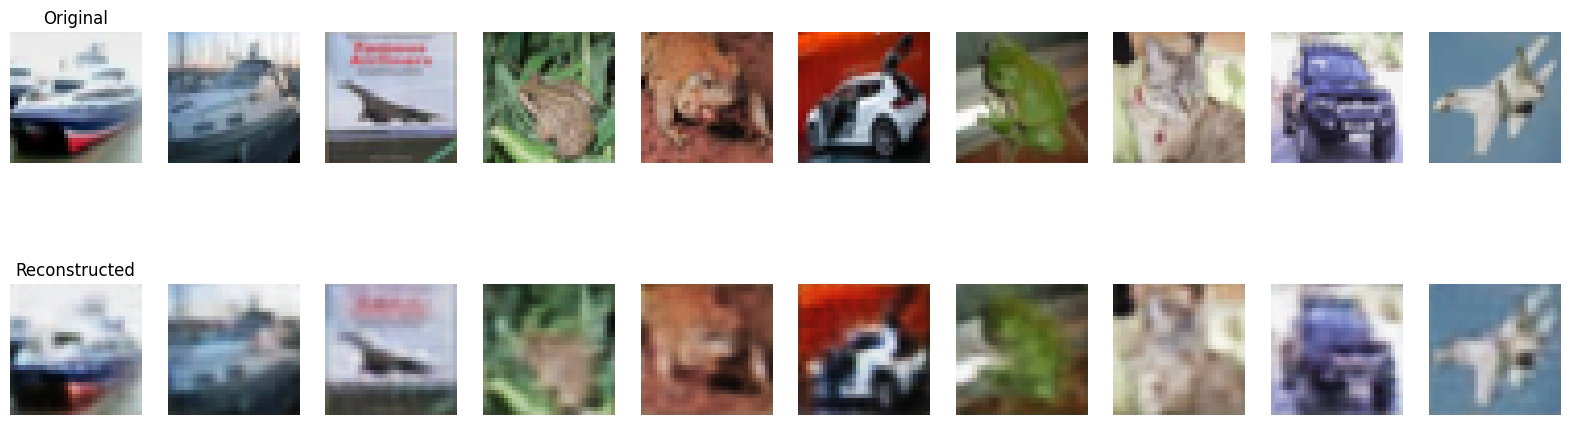

In [11]:
# decoded_imgs에 오토인코더의 '예측'을 할당해줍시다
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 6))

for i in range(1, n + 1):
    # 원본 이미지
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.axis("off")
    if i == 1:
        plt.title("Original")

    # 복원 이미지
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
    if i == 1:
        plt.title("Reconstructed")

plt.show()

**💡 결과 해석**
- **윗줄**은 원본 CIFAR-10 이미지입니다.
- **아랫줄**은 AutoEncoder가 복원한 이미지입니다.
- **오토인코더**는 RGB 32×32 이미지를 **압축했다가 복원**하므로, 완벽히 동일하진 않아도 **주요 색상과 윤곽을 재현**한 것을 볼 수 있습니다!

## 🔍 2. VAE(Variational AutoEncoder)

### 2-1. 데이터 준비

In [12]:
# CIFAR-10 데이터 로드
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# 정규화
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("훈련 데이터:", x_train.shape)
print("테스트 데이터:", x_test.shape)

훈련 데이터: (50000, 32, 32, 3)
테스트 데이터: (10000, 32, 32, 3)


### 2-2. VAE 모델 정의
- **Encoder**: 이미지를 잠재공간의 평균($\mu$)과 로그 분산($log\sigma^2$)으로 압축
- **Reparametrization Trick**: $z = \mu + \sigma \cdot \epsilon$
- **Decoder**: $z$로부터 이미지를 복원

In [13]:
latent_dim = 64  # 잠재공간 크기

In [14]:
# ----- 인코더 ----- 활성화함수는 렐루!
encoder_inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

VAE의 목적은 **입력** $X$를 **확률 분포** $P(z|X)$를 따르는 **잠재 벡터 $z$로 인코딩**하는 것입니다.

이 과정에서 **$z$를 샘플링**하게 되는데, \
**일반적인 무작위 샘플링**은 **역전파(Backpropagation)를 통해 모델의 가중치를 업데이트할 수 없다**는 문제가 있습니다.

**재매개변수화 트릭**은 이 문제를 해결하여,\
$z$를 생성하는 과정에 **'무작위성(Randomness)'을 유지**하면서도 **'미분 가능성(Differentiability)'을 확보**합니다.

In [15]:
# 재매개변수화 트릭(Reparametrization trick)
def sampling(args):
    z_mean, z_log_var = args        # z의 평균과 로그_분산을 샘플링합시다!
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim)) #무작위성을 줍시다.
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 560,320 (2.14 MB)

 Trainable params: 560,320 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# ----- 디코더 -----
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,499 (1.23 MB)

 Trainable params: 322,499 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

### 2-3. train용 VAE 클래스 정의
1. **VAE의 총 손실** = **재구성 손실** + **KL 발산 손실**

2. **재구성(reconstruction) 손실**은 일반적인 **오토인코더의 손실과 동일**하며, **VAE의 압축 및 복원 능력**을 담당합니다.
   - **목표**는 원본 데이터 ($X$)와 디코더가 복원한 출력 ($\hat{X}$) 사이의 **차이를 최소화**하는 것입니다.
   - 모델이 **입력 데이터의 특징을 잘 인코딩**하여 **정확하게 복원할 수 있도록 강제**하는 역할입니다!

3. **KL(Kullback-Leibler) 발산 손실**은 VAE가 단순한 오토인코더를 넘어 **새로운 데이터를 생성할 수 있게 만드는** 핵심 요소입니다.
   - **목표**는 **인코더가 학습한 잠재 공간의 분포** $P(z|X)$가 **미리 정의된 이상적인 분포** (Prior Distribution, 보통 표준 정규 분포)와 **최대한 유사하도록 강제**하는 것입니다.
   - 역할로는 **잠재 공간 $Z$가 규칙적이고 연속적인 구조**를 갖게 합니다. \
   잠재 공간의 **빈틈이 없도록** 만들어, 임의의 $z$를 샘플링해도 **의미 있는 데이터를 생성**할 수 있게 합니다 (Generative, 생성 능력 부여).

In [17]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        super(VAE, self).compile(**kwargs)
        self.optimizer = optimizer

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.recon_loss_tracker,
                self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # 재구성 손실 (픽셀별 MSE)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1,2,3]))
            # KL 손실
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(data - reconstruction), axis=[1, 2, 3])
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = recon_loss + kl_loss

        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss
        }

### 2-4. VAE 학습

In [18]:
# 모델 생성
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda x, y: 0.0  # placeholder loss (validation용)
)

In [19]:
# 학습 에폭은 30, 배치사이즈는 128
history = vae.fit(
    x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - kl_loss: 0.7760 - loss: 191.0826 - recon_loss: 190.3066 - val_kl_loss: 11.5045 - val_loss: 151.6718 - val_recon_loss: 140.1673
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 11.0138 - loss: 123.6585 - recon_loss: 112.6448 - val_kl_loss: 14.8889 - val_loss: 134.0066 - val_recon_loss: 119.1178
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 14.3254 - loss: 110.5323 - recon_loss: 96.2069 - val_kl_loss: 18.1564 - val_loss: 121.1053 - val_recon_loss: 102.9489
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 16.1644 - loss: 104.7643 - recon_loss: 88.5999 - val_kl_loss: 18.7370 - val_loss: 120.6061 - val_recon_loss: 101.8690
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 16.6977 - loss: 100.7368 - recon_loss: 84.0392 - val_kl_loss: 18.5847 - val_loss: 117.2834 - val_recon_loss: 98.6986
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 16.5121 - loss: 96.4544 -

### 2-5. 재복원 결과 시각화

In [20]:
# 복원 인코더와 디코더의 '예측'값입니다.
# 인코더는 x_test로 예측하고, 디코더는 z로 예측합니다
z_mean, _, z = encoder.predict(x_test)
decoded_imgs = decoder.predict(z)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


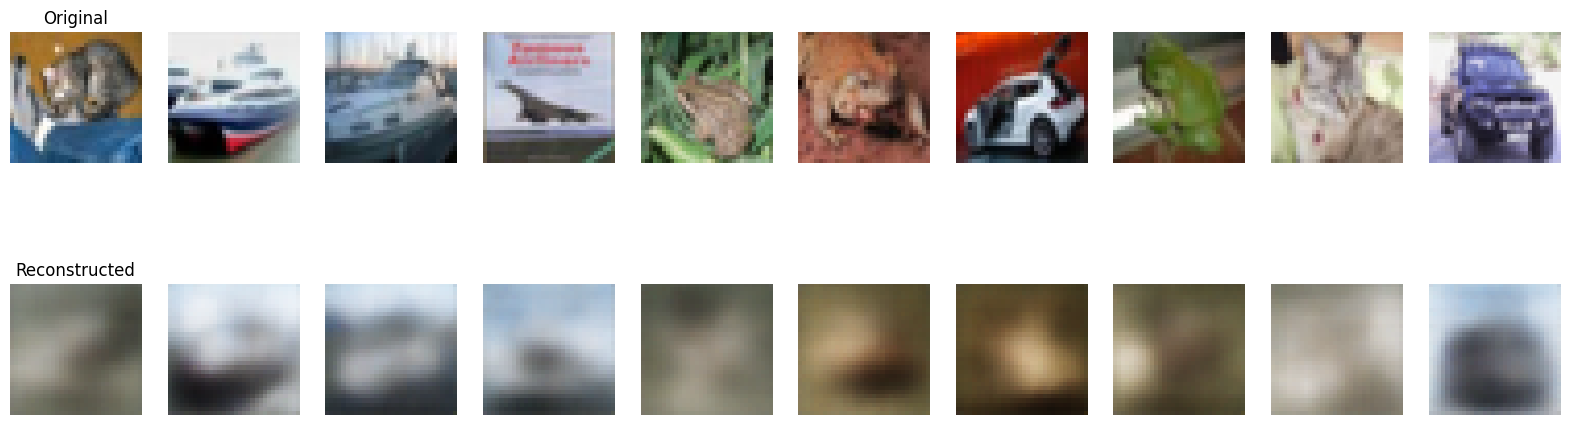

In [21]:
# 시각화

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    # 복원 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
    if i == 0:
        plt.title("Reconstructed")
plt.show()

**💡 결과 해석**
- **윗줄**은 CIFAR-10 원본 이미지입니다.
- **아랫줄**은 VAE가 복원한 이미지입니다.
- 재복원 품질이 좋지 않은 것을 볼 수 있습니다. VAE는 잠재공간(latent space)을 학습해 **새로운 이미지 샘플링/생성**을 목표로 하기 때문입니다.
- AE와 달리 VAE는 **분포 학습**을 하는 것이기 때문에 처음엔 흐릿한 게 정상입니다. **더 많은 특징 정보들을 학습한 후에야 비교적 명확한 이미지가 생성**될 수 있습니다!!

## 🔍 3. GAN

### 3-1. 데이터 준비
- 캐글에 있는 고양이 데이터를 로드해오겠습니다.

In [22]:
!mkdir -p data
!curl -L -o data/archive.zip https://www.kaggle.com/api/v1/datasets/download/spandan2/cats-faces-64x64-for-generative-models

# 압축 해제
!unzip -q data/archive.zip -d data/

# 구조 확인
!ls data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 95.9M  100 95.9M    0     0  80.4M      0  0:00:01  0:00:01 --:--:--  128M
archive.zip  cats


### 3-2. 생성자(Generator) 모델 정의

In [23]:
# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

### 3-3. 판별자(Discriminator) 모델 정의

In [24]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### 3-4. 데이터셋 로더 및 모델/가중치 초기화

다운받은 고양이 이미지를 가져오는 **코드와 모델을 초기화**하고, **각 모델의 가중치를 초기화**하는 코드를 만들어봅시다. \
이 코드는 고양이 이미지 데이터셋을 로드하여 **DataLoader 형태로 반환**합니다.

**이미지를 64x64 크기로 조정**하고 (0.5, 0.5, 0.5)평균 및 표준편차로 정규화 하여 모델 학습에 맞게 변환합니다.

- nomalize((0.5,0.5,0.5),(0.5,0.5,0.5)) 이렇게 0.5세트가 2개인걸 알 수 있습니다. 0.5 세 개가 한세트인 이유는 RGB각각을 한세트로 만들기 때문입니다. 그래서 첫번째 세트는 RGB의 평균들, 두번째는 RGB의 표준편차들입니다.

- 그럼 왜 정규화를 했을까요?

  - .Nomalize(평균값으로 데이터중앙정렬, 표준편차값으로 데이터 스케일링). 평균값으로는 데이터 중앙정렬을, 표준편차값으로는 데이터스케일링을 하기 위해서입니다!

- 데이터 중앙 정렬:
  - 각 채널(RGB)에 대해 평균값인 0.5를 빼주면 픽셀 값들이 0 근처에 분포하게 됩니다. 이렇게 데이터를 중앙에 정렬하면 최적화 과정이 더 빠르게 수렴하는 데 도움이 됩니다.

- 데이터 스케일링:
  - 각 채널의 표준편차인 0.5로 나누어주면 픽셀 값들이 대략 [-1, 1] 범위로 스케일링됩니다. 많은 신경망 활성화 함수들은 입력값이 이 범위에 있을 때 가장 잘 작동합니다. ToTensor() 변환 후 0에서 1 사이였던 픽셀 값들이 이제 -1에서 1 사이로 매핑되는 것이지요!


In [32]:
import os
import time
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import numpy as np
import cv2
import urllib.request
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, optimizers

Conv2D = layers.Conv2D
MaxPooling2D = layers.MaxPooling2D
Conv2DTranspose = layers.Conv2DTranspose
Concatenate = layers.Concatenate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
# 데이터셋 로더 설정
def load_data(batch_size):
    dataset = ImageFolder(
        root="data/cats",
        transform=transforms.Compose([
            transforms.Resize(64),       #크기 재설정
            transforms.CenterCrop(64),
            transforms.ToTensor(),        #텐서화
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),   #정규화
        ])
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

아래 코드에서 initialize_models 함수는 Generator와 Discriminator 모델을 초기화하고, 각 모델의 가중치를 weights_init 함수로 설정한 수 반환하는 코드입니다.

weights_init 함수는 Convolution 및 BatchNorm 레이어의 가중치를 초기화하는 함수로 각 모델의 초기 가중치를 설정해서 학습의 안전성을 높입니다.

Convolution 레이어는 평균이 0, 표준편차가 0.02인 분포로 초기화되고\
BatchNorm 레이어는 평균이 1, 표준편차가 0.02인 정규분포로 초기화됩니다.

In [33]:
# 모델 초기화
def initialize_models(nz, ngf, ndf, nc, device):
    netG = Generator(nz, ngf, nc).to(device)
    netD = Discriminator(nc, ndf).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    return netG, netD

# 가중치 초기화 함수
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 3-5. GAN 학습

이제 모델을 트레이닝하는 함수를 만듭니다.

fixed_noise을 설정해서 고정된 latent vector을 사용해 학습 과정 동안 생성된 이미지가 어떻게 변하는지 관찰해봅시다.

In [34]:
#옵티마이저는 아담
def train_dcgan(num_epochs, dataloader, netG, netD, device, fixed_noise, save_interval=5):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G_losses, D_losses, D_accuracies = [], [], []

    # tqdm epoch 루프
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (real_images, _) in loop:
            ############################
            # (1) Discriminator 학습
            ############################
            netD.zero_grad()
            real_images = real_images.to(device)
            b_size = real_images.size(0)

            label_real = torch.ones(b_size, device=device)
            output_real = netD(real_images).view(-1)
            errD_real = criterion(output_real, label_real)
            D_x = output_real.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label_fake = torch.zeros(b_size, device=device)
            output_fake = netD(fake_images.detach()).view(-1)
            errD_fake = criterion(output_fake, label_fake)
            D_G_z1 = output_fake.mean().item()

            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            ############################
            # (2) Generator 학습
            ############################
            netG.zero_grad()
            label_gen = torch.ones(b_size, device=device)
            output_gen = netD(fake_images).view(-1)
            errG = criterion(output_gen, label_gen)
            errG.backward()
            D_G_z2 = output_gen.mean().item()
            optimizerG.step()

            # tqdm 진행률바에 정보 업데이트
            loop.set_postfix({
                "Loss_D": f"{errD.item():.3f}",
                "Loss_G": f"{errG.item():.3f}",
                "D(x)": f"{D_x:.3f}",
                "D(G(z))": f"{D_G_z1:.3f}/{D_G_z2:.3f}"
            })

        # --- 로그 저장 ---
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_accuracies.append(D_x)

        # --- 결과 이미지 저장 ---
        if epoch % save_interval == 0 or epoch == num_epochs - 1:
            os.makedirs("results", exist_ok=True)
            with torch.no_grad():
                fake_images_fixed = netG(fixed_noise).detach().cpu()
                fake_images_fixed = (fake_images_fixed + 1) / 2
            vutils.save_image(fake_images_fixed, f"results/fake_samples_epoch_{epoch}.png")

    return G_losses, D_losses, D_accuracies

이제 하이퍼파라미터들을 설정하고 학습을 진행해봅시다.

latent vector의 사이즈는 100, 배치 사이즈는 128로 두고 50 에포크 동안 학습시켜보겠습니다.

In [35]:
# 주요 하이퍼파라미터 설정
nz = 100    # latent vector size
ngf = 64    # size of feature maps in generator
ndf = 64    # size of feature maps in discriminator
nc = 3      # number of color channels
batch_size = 128
num_epochs = 50
save_interval = 5

In [36]:
# 학습 프로세스 실행   T4기준 22분 소요
dataloader = load_data(batch_size)
netG, netD = initialize_models(nz, ngf, ndf, nc, device)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

G_losses, D_losses, D_accuracies = train_dcgan(
    num_epochs, dataloader, netG, netD, device, fixed_noise, save_interval
)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/124 [00:00<?, ?it/s]

### 3-6. 학습 후 생성자(Generator)가 만든 가짜 이미지 확인

result 파일에서 낮은 에폭의 결과와 높은 에폭의 결과를 비교해봅시다.

Generated image after epoch 5:


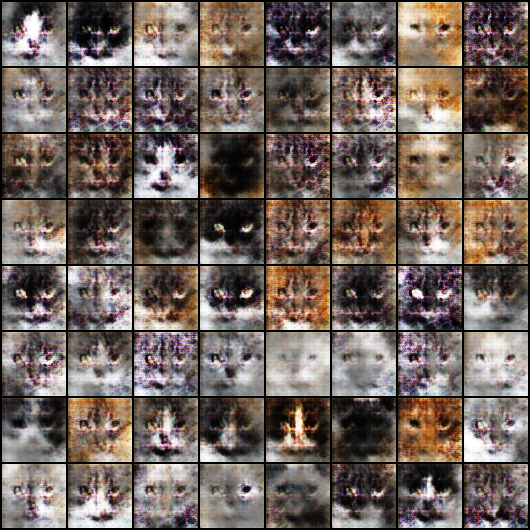

Generated image after epoch 49:


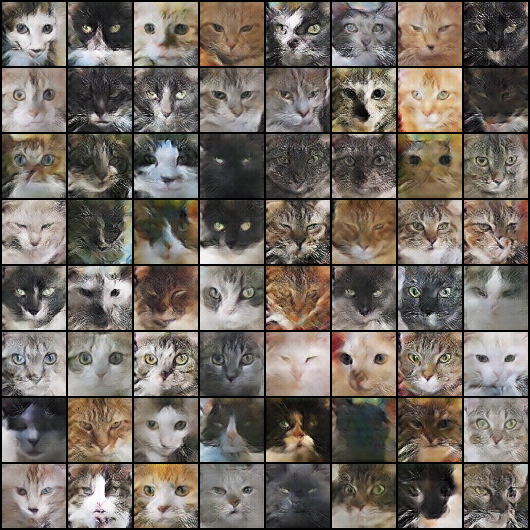

In [37]:
from IPython.display import Image, display

print("Generated image after epoch 5:")
display(Image('/content/results/fake_samples_epoch_5.png'))

print("Generated image after epoch 49:")
display(Image('/content/results/fake_samples_epoch_49.png'))

## 🔍 4. Diffusion Model - "Stable Diffusion"

- **Stable Diffusion**은 **VAE + Diffusion U-Net 구조**로 되어 있습니다.

  - 이때의 VAE는 수억 장의 이미지로 **사전학습(pretrained) 된 상태**입니다.

- 따라서 **이미지 ↔︎ latent vector 변환**을 매우 정밀하게 수행할 수 있습니다.

### 4-1. 데이터 준비

In [6]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터 로드
(x_train, y_train), (_, _) = cifar10.load_data()

# 자동차 클래스만 필터링 (class 1)
car_idx = np.where(y_train.flatten() == 1)[0]
cars = x_train[car_idx]

# 0~1 정규화, 그레이스케일 변환
cars = cars.astype('float32') / 255.0
cars_gray = np.dot(cars[...,:3], [0.299, 0.587, 0.114])[..., np.newaxis]  # (N,32,32,1)

# 학습용으로 256x256 크기로 업샘플링 (원하면 그대로 32x32로도 가능)
cars_resized = np.array([cv2.resize(img, (32,32)) for img in cars_gray])


### 4-2. 순방향 확산(Forward Diffusion) 구현
- 2차원 강아지 이미지에 점진적으로 노이즈를 추가하는 과정을 구현해봅시다.

In [5]:
import gc, torch, tensorflow as tf

gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [7]:
# 이미지에 정규분포를 따르는 노이즈를 추가하는 함수입니다.
# 노이즈 크기는 noise_level로 조절됩니다.
# min_value, max_value: 픽셀값의 하한/상한 범위
def add_noise(img, noise_level, min_value=0.0, max_value=1.0):
    """
    img: 입력 이미지 (0~1 정규화)
    noise_level: 표준편차 수준
    """
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise       # img에 노이즈를 추가해줍시다
    noisy_img = np.clip(noisy_img, min_value, max_value)
    return noisy_img, noise


In [8]:
# 이미지에 점진적으로 노이즈를 추가해 여러 단계의 노이즈 이미지를 생성하는 함수입니다.
def forward_diffusion(imgs, beta_start, beta_end, num_steps, min_value=0.0, max_value=1.0):
    """
    imgs: (N,H,W,1)
    beta_start, beta_end: 베타 값 범위 (노이즈 강도)
    num_steps: 확산 단계 수
    """
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)

    noisy_images, noise_list = [], []

    for t in range(num_steps):
        noise_level = np.sqrt(1 - alpha_bars[t])     # DDPM 수식에 맞춘 노이즈 크기
        noisy, noise = add_noise(imgs, noise_level, min_value, max_value)  #위에서 정의한 노이즈 추가함수!
        noisy_images.append(noisy)
        noise_list.append(noise)

    return np.array(noisy_images), np.array(noise_list), betas, alphas, alpha_bars

In [ ]:
# 순방향 확산 수행
num_steps = 100
noisy_images, noise_list, betas, alphas, alpha_bars = forward_diffusion(
    cars_resized,        # CIFAR-10 자동차 이미지 (0~1)
    beta_start=0.0001,
    beta_end=0.02,
    num_steps=num_steps,
    min_value=0.0,
    max_value=1.0
)

# 결과 시각화
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(noisy_images[i*10][0,...,0], cmap='gray')  # 첫 번째 이미지 기준으로 확인
    plt.title(f"Step {i*10}")
    plt.axis('off')
plt.suptitle("Forward Diffusion (Adding Noise on CIFAR10 car)", fontsize=14)
plt.tight_layout()
plt.show()


### 4-3. 역방향 확산(Reverse Diffusion) 구현

In [ ]:
# U-Net 모델 정의
def build_unet(input_shape):
    inputs = Input(input_shape)

    # 인코더
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # 디코더
    u1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(p2)
    u1 = Concatenate()([u1, c2])
    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c3)
    u2 = Concatenate()([u2, c1])
    c4 = Conv2D(64, (3,3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    outputs = Conv2D(1, (1,1), activation='linear')(c4)  # 노이즈 예측용
    return Model(inputs, outputs)

In [ ]:
input_shape = (64,64,1)
model = build_unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),   #학습률
              loss='mean_squared_error')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     65,664 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64, 1) │         65 │ conv2d_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 910,913 (3.47 MB)

 Trainable params: 910,913 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 입력: 노이즈가 섞인 이미지 / 타겟: 실제 노이즈
noisy_images_tensor = noisy_images.reshape(-1,64,64,1).astype(np.float32)
noise_tensor = noise_list.reshape(-1,64,64,1).astype(np.float32)

In [ ]:
num_epochs = 50
model.fit(
    noisy_images_tensor,
    noise_tensor,
    epochs=num_epochs,
    batch_size=64,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# 역방향 확산(Reverse Diffusion)
# DDPM 공식을 이용해 모델이 예측한 노이즈를 제거하며 원본으로 복원합니다.

def reverse_diffusion_ddpm(model, num_steps, betas, alphas, alpha_bars, shape):
    x_t = np.random.randn(*shape)  # 완전한 노이즈에서 시작
    denoised_steps = [x_t]

    for t in reversed(range(num_steps)):
        predicted_noise = model.predict(x_t[np.newaxis, ...])[0]     #예측하기!
        if t > 0:
            noise = np.random.randn(*x_t.shape)
        else:
            noise = 0

        # DDPM 역확산 공식
        x_t = (
            1 / np.sqrt(alphas[t])
            * (x_t - ((1 - alphas[t]) / np.sqrt(1 - alpha_bars[t])) * predicted_noise)
            + np.sqrt(betas[t]) * noise
        )
        x_t = np.clip(x_t, 0, 1)
        denoised_steps.append(x_t)

    return denoised_steps


In [ ]:
# DDPM 역확산 수행
num_steps = 100
reverse_steps = reverse_diffusion_ddpm(
    model, num_steps, betas, alphas, alpha_bars, (64,64,1)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


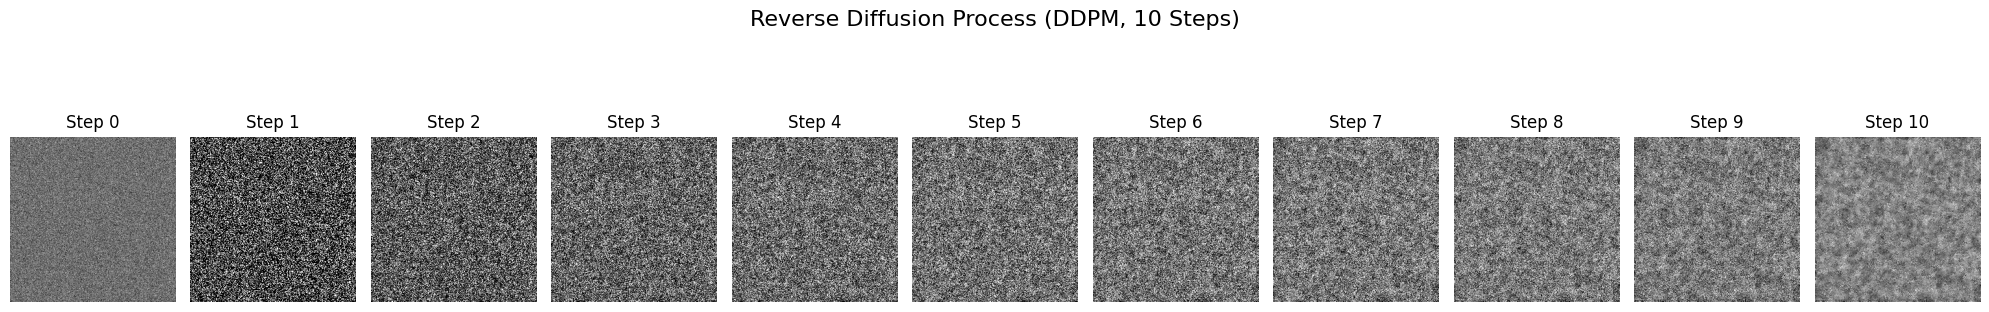

In [ ]:
# 결과 시각화
plt.figure(figsize=(20,4))
for i, img in enumerate(reverse_steps[::10]):  # 10스텝 간격으로 표시
    plt.subplot(1, len(reverse_steps)//10, i + 1)
    plt.imshow(img[...,0], cmap='gray')
    plt.title(f"Step {i*10}")
    plt.axis('off')

plt.suptitle("Reverse Diffusion Process (CIFAR10 Cars, DDPM)", fontsize=16)
plt.tight_layout()
plt.show()


# 숙제 끝!~
